
# Experiment - Forecast of Volatility using LSTM 2 Model

In [1]:
# Import libraries
import os, glob
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, SimpleRNN
from keras import backend as K
from keras import regularizers
# Set GPU device
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]=""

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Using TensorFlow backend.


In [2]:
def qlike(y_true, y_pred):
    return K.mean((K.log(y_pred) + (y_true / y_pred)), axis=-1)

In [3]:
#Summary Table
csv = (glob.glob('*.csv'))[0]
print ('Filename for Summary Table: ' + csv)

#Data Preparation from CSV  
df_Summary = pd.read_csv(csv,index_col=0,engine = 'python')
n_days = 252 #Number of days to use as dataset based on average trading days per year 

#Define empty array
dataset = np.empty((n_days, 0)) # Preallocate the array

#Create Dataset
for i in range(0, len(df_Summary)):
    try:
        ticker = df_Summary['Ticker'][i]
        df_ticker = pd.read_csv('Data//'+ ticker + '//' + ticker + '.csv',engine = 'python')

        #Create new dataset array based on 'Return_log' and 'Realized_Volatility_20D'
        asset=df_ticker[['Ret_Log','Vol']].tail(n_days).values
        dataset = np.append(dataset, asset, axis=1)
    
    except:
        print(ticker)
        continue

Filename for Summary Table: Summary_DJIA30.csv


In [4]:
dataset

array([[ 1.23546992e-02,  2.97494860e-01,  1.77519654e-02, ...,
         1.94741946e-01,  2.32603887e-03,  1.97955285e-01],
       [-1.55632231e-02,  2.97941473e-01, -8.38560507e-05, ...,
         1.94753656e-01, -4.39853907e-03,  1.97976188e-01],
       [-2.73270443e-02,  2.96831315e-01, -9.42924728e-03, ...,
         1.94608831e-01, -5.32979763e-03,  1.98001285e-01],
       ...,
       [ 3.23173555e-02,  4.10267714e-01,  8.61038339e-02, ...,
         2.87581951e-01,  5.38916038e-02,  4.12038808e-01],
       [ 2.08766436e-02,  4.08080057e-01, -5.19944470e-02, ...,
         2.87709628e-01, -2.10802624e-02,  4.12076403e-01],
       [-1.62303235e-02,  4.08383894e-01, -3.26364134e-02, ...,
         2.87883106e-01, -7.43563426e-02,  4.18109462e-01]])

In [5]:
# Forecast for next 20 days lookahead days by initialising value of 1
a= np.concatenate((dataset, np.ones((20,56))), axis=0)
dataset = a


In [6]:
# Normalize data
factor = 2

# Calculate second raw moment
M2 = np.mean(dataset ** 2, axis=0) ** (1/2)

# Apply scaling
dataset_norm = (1/factor) * (dataset / M2)

In [7]:
def create_dataset(dataset, look_back=1):
    """
    Function to convert series from dataset to supervised learning problem
    """
    data_x, data_y = [], []

    for i in range(len(dataset) - look_back):

        # Create sequence of length equal to look_back
        x = dataset[i:(i + look_back), :]
        data_x.append(x)

        # Take just the volatility for the target
        data_y.append(dataset[i + look_back, 1::2])

    return np.array(data_x), np.array(data_y)

In [8]:
# Convert series to supervised learning problem
look_back = 20
X, y = create_dataset(dataset_norm, look_back)

# Declare variables
n_features = dataset.shape[1]
n_assets = y.shape[1]


In [9]:
# Split dataset
training_days = 90
X_train, X_test = X[:training_days], X[training_days:]
y_train, y_test = y[:training_days], y[training_days:]

# Prepare the 3D input vector for the LSTM
X_train = np.reshape(X_train, (-1, look_back, n_features))
X_test = np.reshape(X_test, (-1, look_back, n_features))

In [10]:
batch_size = 1

# Create the model
model = Sequential()
model.add(LSTM(len(dataset[0]),
               input_shape=(look_back, n_features),
               batch_size=batch_size,
               return_sequences=True,
               stateful=True,
               activity_regularizer=regularizers.l1_l2(),
               recurrent_regularizer=regularizers.l1_l2()))
model.add(Dropout(0.2))
model.add(LSTM(int(len(dataset[0])/2),
               return_sequences=False,
               stateful=True,
               activity_regularizer=regularizers.l1_l2(),
               recurrent_regularizer=regularizers.l1_l2()))
model.add(Dense(n_assets, activation='softplus'))   

In [11]:
# Compile the LSTM model
model.compile(loss=qlike, optimizer='rmsprop')

In [12]:
## Training and evaluating the model (On-line learning)

# Create empty arrays
y_pred = np.empty((0, n_assets))
y_true = np.empty((0, n_assets))

for j in range(training_days - look_back + 1, X.shape[0]):
    if j == (training_days - look_back + 1):

        # First training days for training
        X_train = X[:j]
        y_train = y[:j]

        # Next day for forecasting
        X_test = X[j].reshape(1, look_back, n_features)

        # Ensure the correct shape for LSTM
        X_test = np.tile(X_test, (batch_size, 1, 1))
        y_test = np.tile(y[j], (batch_size, 1))

        # Training epochs
        epochs = 90
    
    else:

        # Available data to refine network state
        X_train = X_test
        y_train = y_test

        # Ensure the correct shape for LSTM
        X_test = X[j].reshape(1, look_back, n_features)
        X_test = np.tile(X_test, (batch_size, 1, 1))
        y_test = np.tile(y[j], (batch_size, 1))

        # Epochs for updating
        epochs = 20
        
    # Fit the model
    for i in range(epochs):
        model.fit(X_train,
                  y_train,
                  epochs=1,
                  batch_size=batch_size,
                  verbose=0,
                  shuffle=False)
        model.reset_states()
    
    # Evaluate the model
    # Make predictions
    predicted_output = model.predict(X_test, batch_size=batch_size)

    predicted_output = predicted_output[0].reshape(1, n_assets)
    true_output = y_test[0].reshape(1, n_assets)

    # Save current prediction into an array
    y_pred = np.append(y_pred, predicted_output, axis=0)
    y_true = np.append(y_true, true_output, axis=0)

In [13]:
# Invert scaling
def invert_standardization(data, M2, factor):
  
    # Consider just volatility series
    M2 = M2[1::2]

    data = factor * data * M2

    return data

# Apply inversion
y_pred = invert_standardization(y_pred, M2, factor)
y_true = invert_standardization(y_true, M2, factor)

In [17]:
# Determine Average Volatility performance for each DJIA stock
volatility_array = []
for i in range(0,28):
    sum_volatility = 0
    for j in range(0, 20):
        k = y_pred[161+j][i]
        sum_volatility += k
    average_volatility = 0
    average_volatility = sum_volatility/20
    volatility_array = np.append(volatility_array, average_volatility)

ticker_array = []
for i in range(len(df_Summary)):
    ticker = df_Summary['Ticker'][i]
    ticker_array = np.append(ticker_array, ticker)
    
df = pd.DataFrame({'DJIA': ticker_array, 'Predicted Volatility': volatility_array})
df = df.sort_values(by='Predicted Volatility', ascending=True)

df

,DJIA,Predicted Volatility
24,VZ,0.375472
26,WMT,0.436963
11,JNJ,0.499450
16,MRK,0.567088
15,MMM,0.596872
18,NKE,0.617944
3,CAT,0.632138
25,WBA,0.654401
20,PG,0.664318
19,PFE,0.677961


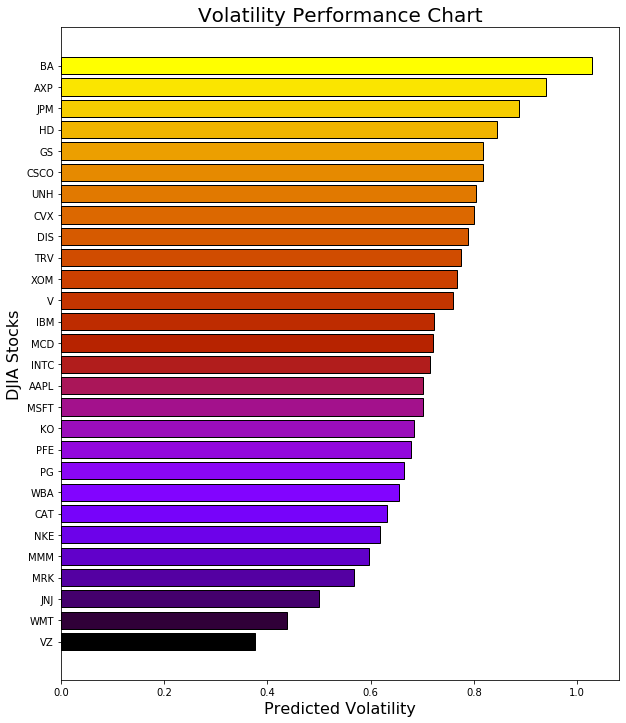

In [15]:
# Plot of Bar Chart
cmap = plt.get_cmap('gnuplot')
colors = [cmap(i) for i in np.linspace(0, 1, len(df_Summary))]

plt.figure(figsize=(10,12))
plt.barh(df['DJIA'],df['Predicted Volatility'], 
         color=colors,edgecolor='black')
plt.xlabel('Predicted Volatility', fontsize=16)
plt.ylabel('DJIA Stocks', fontsize=16)
plt.title('Volatility Performance Chart',fontsize=20)
plt.show()

In [16]:
len(ticker_array)

28